<a href="https://colab.research.google.com/github/Dhamu785/AI-scratch/blob/main/PyTorch/03_Multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Import libaries and setting device agnostic code**

In [1]:
import numpy as np
import torch as t
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import torchmetrics as tm
import seaborn as sns
from sklearn.metrics import classification_report

In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
device = 'cuda' if t.cuda.is_available() else 'cpu'

print("Available device = ", device)

Available device =  cpu


In [7]:
t.__version__

'2.3.0+cu121'

## **2. Create the dataset**

### **2.1 From sklearn**

In [8]:
# Hyper parameters for dataset

NUM_FEATURES = 2
NUM_CLASS = 4
RANDOM_SEED = 42

X, y = make_blobs(1000, NUM_FEATURES, centers=NUM_CLASS, cluster_std=2, random_state=RANDOM_SEED)

print(f"{X.shape = }, {y.shape = }")
print(f"{X.dtype = }, {y.dtype = }") # numpy default datatype is float64 whereas torch likes float32


X.shape = (1000, 2), y.shape = (1000,)
X.dtype = dtype('float64'), y.dtype = dtype('int64')


In [9]:
print((X/2.0).dtype)

float64


In [10]:
X = t.from_numpy(X).type(t.float32)
y = t.from_numpy(y).type(t.float32)

print(f"{X.shape = }, {y.shape = }")
print(f"{X.dtype = }, {y.dtype = }")

X.shape = torch.Size([1000, 2]), y.shape = torch.Size([1000])
X.dtype = torch.float32, y.dtype = torch.float32


### **2.2 Train test split**

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print(f"{len(x_train) = }, {len(x_test) = }\n{len(y_train) = }, {len(y_test) = }")

len(x_train) = 800, len(x_test) = 200
len(y_train) = 800, len(y_test) = 200


### **2.3 Visualize the data**

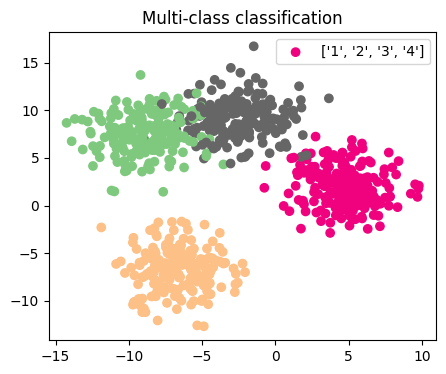

In [12]:
plt.figure(figsize=(5,4))
plt.style.use('fast')
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap=plt.cm.Accent_r, label=["1", "2", "3", "4"])
plt.title("Multi-class classification")
plt.legend();
# plt.xlabel("x_train[:,0]")
# plt.ylabel("y_train[:,1]");

## **3. Building the model**

### **3.1 About labels**

In [13]:
# about the y

print(t.unique(y))
pd.DataFrame(np.array(y)).value_counts().reset_index()

tensor([0., 1., 2., 3.])


,0,count
0,0.0,250
1,1.0,250
2,2.0,250
3,3.0,250


### **3.2 Build model and set loss and optimizer**

In [14]:
class multi_class(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2,16),
            # nn.ReLU(),
            nn.Linear(16, 32),
            # nn.ReLU(),
            nn.Linear(32,4)
        )

    def forward(self, x):
        return self.layers(x)

model0 = multi_class()
model0

multi_class(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [15]:
# Creating loss function and optimizer

ls_fun = nn.CrossEntropyLoss()
opt = t.optim.SGD(model0.parameters(), lr=0.01)

### **3.3 Model predictions without training**

In [16]:
model0.eval()
with t.inference_mode():
    y_logits = model0(x_test)

print(y_logits[:5])

tensor([[ 0.5764, -0.0680, -0.4688, -0.6760],
        [ 1.1187,  0.3787, -0.2962, -0.1129],
        [-0.9670,  0.3144, -0.1217,  0.5678],
        [ 0.0098, -0.0223, -0.3894, -0.3824],
        [ 1.4044,  0.0789, -0.4766, -0.7373]])


In [17]:
new_var = t.softmax(y_logits,1)[:5]
new_var

tensor([[0.4624, 0.2428, 0.1626, 0.1322],
        [0.4971, 0.2371, 0.1208, 0.1451],
        [0.0864, 0.3113, 0.2013, 0.4011],
        [0.3017, 0.2921, 0.2024, 0.2038],
        [0.6512, 0.1730, 0.0993, 0.0765]])

In [18]:
new_var0 = t.sum(t.softmax(y_logits,1)[0])
new_var0

tensor(1.0000)

In [19]:
t.max(t.softmax(y_logits,1)[0]), t.argmax(t.softmax(y_logits,1)[0])

(tensor(0.4624), tensor(0))

### **3.4 Train and test loop**

In [20]:
def calc_accuracy(y_true, y_pred):
    score = t.eq(y_true, y_pred).sum().item()
    return (score/len(y_true)) * 100

In [21]:
x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(1, epochs+1):
    model0.train()

    y_logits = model0(x_train)
    y_pred = t.argmax(t.softmax(y_logits,1), 1)

    loss = ls_fun(y_logits, y_train.type(t.long))
    accuracy = calc_accuracy(y_train, y_pred)

    opt.zero_grad()
    loss.backward()
    opt.step()

    model0.eval()
    with t.inference_mode():
        y_test_logits = model0(x_test)
        y_test_preds = t.argmax(t.softmax(y_test_logits, 1), 1)

        test_loss = ls_fun(y_test_logits, y_test.type(t.long))
        test_accuracy = calc_accuracy(y_test, y_test_preds)

    if epoch % 100 == 0:
        print(f"Epoch = {epoch}/{epochs} | Train-Loss:{loss:.2f}, accuracy:{accuracy:.2f} | Test-loss:{test_loss:.2f}, accuracy:{test_accuracy}")

Epoch = 100/1000 | Train-Loss:0.17, accuracy:96.00 | Test-loss:0.16, accuracy:96.0
Epoch = 200/1000 | Train-Loss:0.13, accuracy:96.00 | Test-loss:0.12, accuracy:96.5
Epoch = 300/1000 | Train-Loss:0.11, accuracy:96.00 | Test-loss:0.10, accuracy:96.5
Epoch = 400/1000 | Train-Loss:0.10, accuracy:96.00 | Test-loss:0.09, accuracy:97.0
Epoch = 500/1000 | Train-Loss:0.10, accuracy:96.00 | Test-loss:0.09, accuracy:97.0
Epoch = 600/1000 | Train-Loss:0.10, accuracy:96.00 | Test-loss:0.08, accuracy:97.0
Epoch = 700/1000 | Train-Loss:0.10, accuracy:96.12 | Test-loss:0.08, accuracy:97.0
Epoch = 800/1000 | Train-Loss:0.09, accuracy:96.12 | Test-loss:0.08, accuracy:97.0
Epoch = 900/1000 | Train-Loss:0.09, accuracy:96.12 | Test-loss:0.08, accuracy:97.0
Epoch = 1000/1000 | Train-Loss:0.09, accuracy:96.12 | Test-loss:0.08, accuracy:97.0


### **3.5 Data visualization**

In [22]:
def plot_classification(model0_cls_seq=model0):
    plt.figure(figsize=(13,4.5))
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    data = t.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).type(t.float)

    model0_cls_seq.eval()
    with t.inference_mode():
        y_pred = model0_cls_seq(data).squeeze()

    plt.subplot(1,2,1)
    y_pred = t.argmax(t.softmax(y_pred,1), 1)
    plt.contourf(xx, yy, y_pred.detach().numpy().reshape(xx.shape), cmap=plt.cm.BuGn, alpha=0.8)
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train, s=40, cmap='bone')
    plt.title("Train data")
    plt.colorbar()

    model0_cls_seq.eval()
    with t.inference_mode():
        y_pred = model0_cls_seq(data).squeeze()

    plt.subplot(1,2,2)
    y_pred = t.argmax(t.softmax(y_pred, 1), 1)
    plt.contourf(xx, yy, y_pred.detach().numpy().reshape(xx.shape), cmap=plt.cm.tab10, alpha=0.8)
    plt.scatter(x_test[:,0], x_test[:,1], c=y_test, s=40, cmap='viridis')
    plt.title("Test data")
    plt.colorbar()
    plt.show()

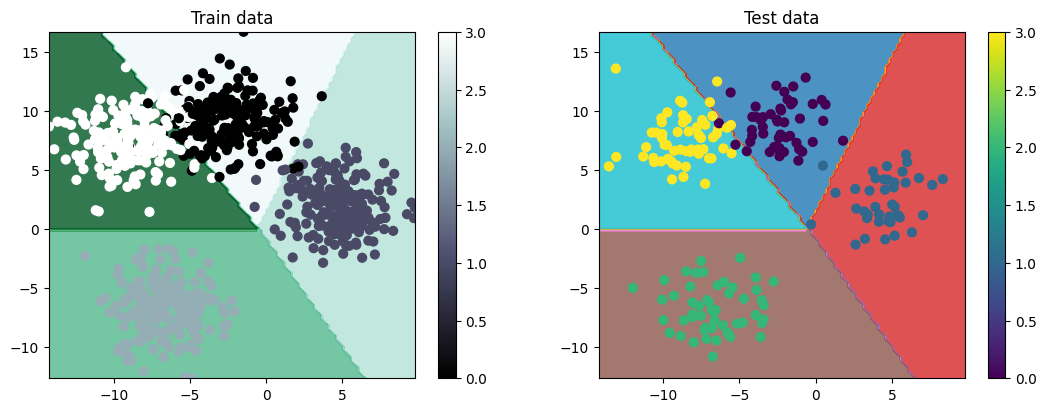

In [23]:
plot_classification()

## **4. Model evaluation**

- Accuracy
- Precision
- ReCall
- F1 Score
- Classification report
- Confusion matrix

In [24]:
accuracy = tm.Accuracy(task="multiclass", num_classes=4)
accuracy(y_test_preds, y_test)

tensor(0.9700)

In [25]:
precision = tm.Precision(task="multiclass", num_classes=4)
precision(y_test_preds, y_test)

tensor(0.9700)

In [26]:
recall = tm.Recall(task="multiclass", num_classes=4)
recall(y_test_preds, y_test)

tensor(0.9700)

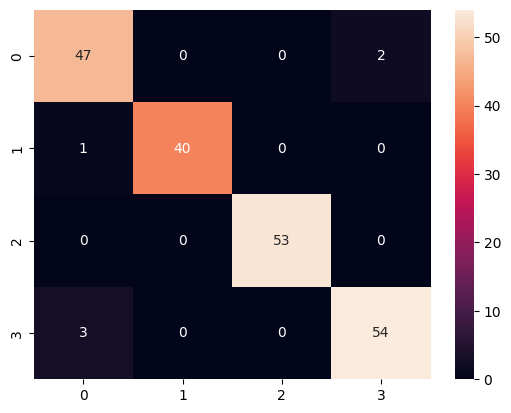

In [27]:
confmat = tm.ConfusionMatrix(task="multiclass", num_classes=4)
cf_mat = confmat(y_test_preds, y_test)
sns.heatmap(cf_mat, annot=True);

In [31]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        49
         1.0       1.00      0.98      0.99        41
         2.0       1.00      1.00      1.00        53
         3.0       0.96      0.95      0.96        57

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



## **5. References**

1. torchmetrics to calculate the accuracy and much more - [Doc](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html)
---